Loading Dataset from kaggle

In [2]:
!mkdir -p ~/ .kaggle
!cp kaggle.json ~/.kaggle/


In [3]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 66% 17.0M/25.7M [00:00<00:00, 177MB/s]
100% 25.7M/25.7M [00:00<00:00, 208MB/s]


Importing Libraries

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import Sequential
from keras.layers import Dense,Embedding,Flatten, LSTM, GlobalAveragePooling1D
import pandas as pd
import numpy as np

Unzipping the file

In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/imdb-dataset-of-50k-movie-reviews.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<Axes: xlabel='sentiment', ylabel='count'>

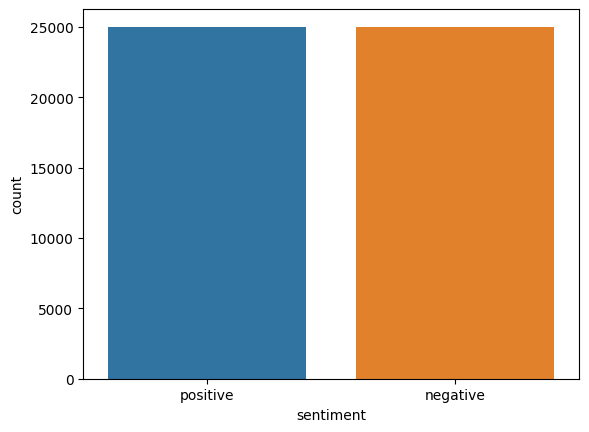

In [9]:
import seaborn as sns
sns.countplot(data=df, x= 'sentiment' )

In [10]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [11]:
X=df['review']
Y=df['sentiment']

spliting data into train and test data

In [12]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=30)

# Tokenize the train data

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [14]:
tokenizer.document_count

40000

In [15]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
len(X_train_sequences)

40000

In [16]:
y_train.shape

(40000,)

# Tokenize the test data

In [17]:
#tokenizer.fit_on_texts(X_test)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
len(X_test_sequences)

10000

In [18]:
from keras.utils import pad_sequences
X_train = pad_sequences(X_train_sequences,padding='post',maxlen=100)
X_test = pad_sequences(X_test_sequences,padding='post',maxlen=100)

Using LSTM with Sequential Model

In [19]:
model = Sequential()
model.add(Embedding(10000,output_dim=1,input_length=100))
model.add(LSTM(32,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 1)            10000     
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 14385 (56.19 KB)
Trainable params: 14385 (56.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5)

Epoch 1/5
1250/1250 [==============================] - 48s 34ms/step - loss: 0.4323 - acc: 0.7865 - val_loss: 0.3439 - val_acc: 0.8523
Epoch 2/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.2875 - acc: 0.8820 - val_loss: 0.3191 - val_acc: 0.8641
Epoch 3/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.2496 - acc: 0.9014 - val_loss: 0.3263 - val_acc: 0.8631
Epoch 4/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.2284 - acc: 0.9097 - val_loss: 0.3579 - val_acc: 0.8588
Epoch 5/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.2158 - acc: 0.9167 - val_loss: 0.4139 - val_acc: 0.8507


In [21]:
model_accuracy = model.evaluate(X_test,y_test)
print(f"Loss: {model_accuracy[0]}")
print(f"Accuracy: {model_accuracy[1]}")


313/313 [==============================] - 1s 5ms/step - loss: 0.4139 - acc: 0.8507
Loss: 0.4139488637447357
Accuracy: 0.8507000207901001


I got accuracy 85% using LSTM model

Saving Model

In [22]:
import tensorflow as tf
tf.keras.models.save_model(model,'LSTM_model_imdb.h5')

<ipython-input-22-4ee49fe00f2e>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'LSTM_model_imdb.h5')


function for plot

In [23]:
import matplotlib.pyplot as plt
def plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(acc,'b',label='Training acc')
  plt.plot(val_acc,'r', label='Validation acc')
  plt.title('Training and Validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(loss, 'b', label='Training loss')
  plt.plot(val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()

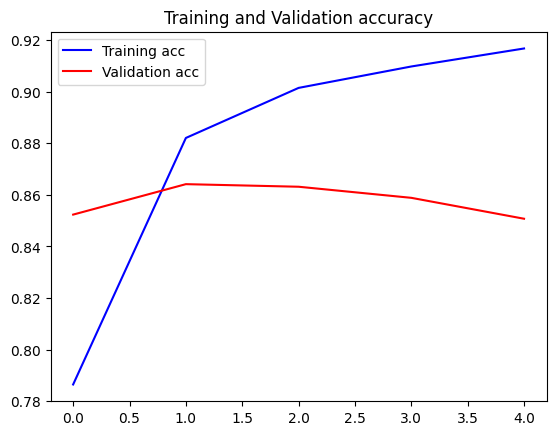

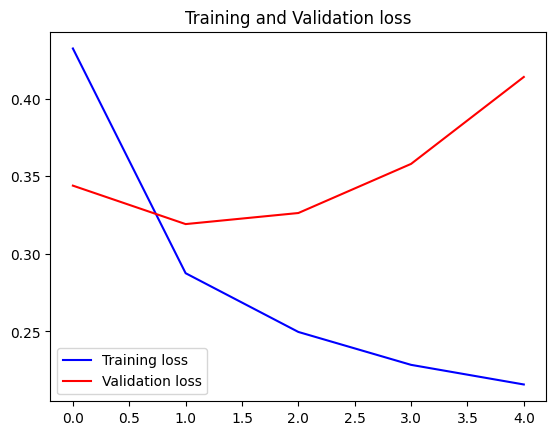

In [24]:
plot(history)

Build model without LSTM

In [40]:
model_1=Sequential([
    Embedding(10000, 32, input_length=100),
    GlobalAveragePooling1D(),
    Dense(16, activation = 'relu'),
    Dense(1, activation='sigmoid')
])

In [41]:
model_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           320000    
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320545 (1.22 MB)
Trainable params: 320545 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
history_1 = model_1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5)

Epoch 1/5
1250/1250 [==============================] - 45s 35ms/step - loss: 0.4247 - acc: 0.8104 - val_loss: 0.3208 - val_acc: 0.8606
Epoch 2/5
1250/1250 [==============================] - 11s 8ms/step - loss: 0.2746 - acc: 0.8858 - val_loss: 0.3194 - val_acc: 0.8627
Epoch 3/5
1250/1250 [==============================] - 9s 8ms/step - loss: 0.2417 - acc: 0.9011 - val_loss: 0.3367 - val_acc: 0.8604
Epoch 4/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2222 - acc: 0.9122 - val_loss: 0.3537 - val_acc: 0.8580
Epoch 5/5
1250/1250 [==============================] - 8s 6ms/step - loss: 0.2080 - acc: 0.9183 - val_loss: 0.3798 - val_acc: 0.8541


In [44]:
model_1.evaluate(X_test,y_test)
print(f"Loss: {model_accuracy[0]}")
print(f"Accuracy: {model_accuracy[1]}")

313/313 [==============================] - 1s 2ms/step - loss: 0.3798 - acc: 0.8541
Loss: 0.3788493871688843
Accuracy: 0.854200005531311


I got accuracy 85%

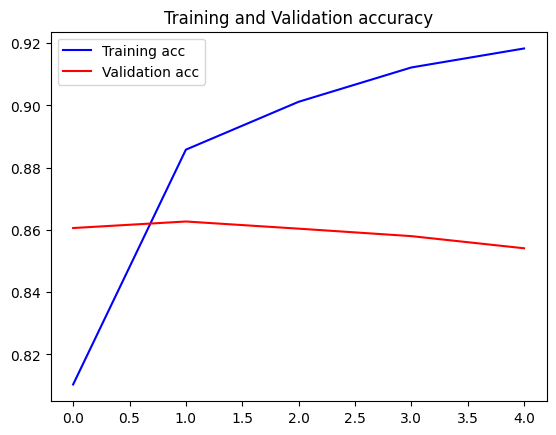

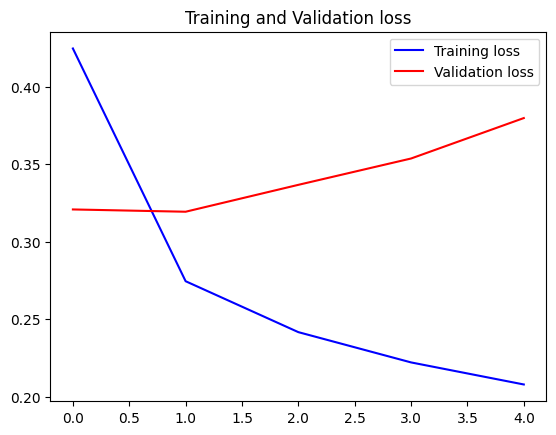

In [81]:
plot(history_1)

Prediction on test data

In [25]:
predictions = model.predict(X_test)*100
for i in range(0,10):
  if predictions[i] >50:
    print("Sentiment Analysis: Positive")
    print("==============================")
  else:
   print("Sentiment Analysis: Negative")
   print("==============================")

313/313 [==============================] - 1s 3ms/step
Sentiment Analysis: Positive
Sentiment Analysis: Positive
Sentiment Analysis: Positive
Sentiment Analysis: Negative
Sentiment Analysis: Negative
Sentiment Analysis: Negative
Sentiment Analysis: Negative
Sentiment Analysis: Positive
Sentiment Analysis: Negative
Sentiment Analysis: Positive


Prediction on new review

In [32]:
sent=["this movie is wonderful and full of comedy. just fantastic. Story is uniqe and powerful. Acting is awesome.","This is worst movie, acting is very bad"]
test_sequences = pad_sequences(tokenizer.texts_to_sequences(sent), maxlen=100)
predictions = model.predict(test_sequences)*100
for i in range(0,len(sent)):
  if predictions[i] >50:
    print(f"Review: {sent[i]}")
    print("Sentiment Analysis: Positive")
    print("==============================")
  else:
    print(f"Review: {sent[i]}")
    print("Sentiment Analysis: Negative")
    print("==============================")

1/1 [==============================] - 0s 28ms/step
Review: this movie is wonderful and full of comedy. just fantastic. Story is uniqe and powerful. Acting is awesome.
Sentiment Analysis: Positive
Review: This is worst movie, acting is very bad
Sentiment Analysis: Negative
